# **ECE1512 Project_A Preperation Part 1: 1-D Digit Classification**

## Drive Mounting

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
os.chdir(r'/content/drive/MyDrive/ECE1512_ProjectA/Project_A_Supp')  # Change the directory to torchRay-master folder

## Requirements

In [5]:
import os
import numpy as np
import pandas as pd
import requests
import scipy
import pickle
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import interp1d
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten
from keras import regularizers
import keras.backend as K
from keras.models import load_model
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import cv2

from tensorflow.keras.applications import xception
import tensorflow as tf

In [6]:
#@title MNIST-1D utils

# transformations of the templates which will make them harder to classify
def pad(x, padding):
    low, high = padding
    p = low + int(np.random.rand()*(high-low+1))
    return np.concatenate([x, np.zeros((p))])

def shear(x, scale=10):
    coeff = scale*(np.random.rand() - 0.5)
    return x - coeff*np.linspace(-0.5,.5,len(x))

def translate(x, max_translation):
    k = np.random.choice(max_translation)
    return np.concatenate([x[-k:], x[:-k]])

def corr_noise_like(x, scale):
    noise = scale * np.random.randn(*x.shape)
    return gaussian_filter(noise, 2)

def iid_noise_like(x, scale):
    noise = scale * np.random.randn(*x.shape)
    return noise

def interpolate(x, N):
    scale = np.linspace(0,1,len(x))
    new_scale = np.linspace(0,1,N)
    new_x = interp1d(scale, x, axis=0, kind='linear')(new_scale)
    return new_x

def transform(x, y, args, eps=1e-8):
    new_x = pad(x+eps, args.padding) # pad
    new_x = interpolate(new_x, args.template_len + args.padding[-1])  # dilate
    new_y = interpolate(y, args.template_len + args.padding[-1])
    new_x *= (1 + args.scale_coeff*(np.random.rand() - 0.5))  # scale
    new_x = translate(new_x, args.max_translation)  #translate
    
    # add noise
    mask = new_x != 0
    new_x = mask*new_x + (1-mask)*corr_noise_like(new_x, args.corr_noise_scale)
    new_x = new_x + iid_noise_like(new_x, args.iid_noise_scale)
    
    # shear and interpolate
    new_x = shear(new_x, args.shear_scale)
    new_x = interpolate(new_x, args.final_seq_length) # subsample
    new_y = interpolate(new_y, args.final_seq_length)
    return new_x, new_y

def get_dataset_args(as_dict=False):
    arg_dict = {'num_samples': 5000,
            'train_split': 0.8,
            'template_len': 12,
            'padding': [36,60],
            'scale_coeff': .4, 
            'max_translation': 48,
            'corr_noise_scale': 0.25,
            'iid_noise_scale': 2e-2,
            'shear_scale': 0.75,
            'shuffle_seq': False,
            'final_seq_length': 40,
            'seed': 42,
            'url': 'https://github.com/greydanus/mnist1d/raw/master/mnist1d_data.pkl'}
    return arg_dict if as_dict else ObjectView(arg_dict)


def to_pickle(thing, path): # save something
    with open(path, 'wb') as handle:
        pickle.dump(thing, handle, protocol=4)


def from_pickle(path): # load something
    thing = None
    with open(path, 'rb') as handle:
        thing = pickle.load(handle)
    return thing

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

# basic 1D templates for the 10 digits
def get_templates():
    d0 = np.asarray([5,6,6.5,6.75,7,7,7,7,6.75,6.5,6,5])
    d1 = np.asarray([5,3,3,3.4,3.8,4.2,4.6,5,5.4,5.8,5,5])
    d2 = np.asarray([5,6,6.5,6.5,6,5.25,4.75,4,3.5,3.5,4,5])
    d3 = np.asarray([5,6,6.5,6.5,6,5,5,6,6.5,6.5,6,5])
    d4 = np.asarray([5,4.4,3.8,3.2,2.6,2.6,5,5,5,5,5,5])
    d5 = np.asarray([5,3,3,3,3,5,6,6.5,6.5,6,4.5,5])
    d6 = np.asarray([5,4,3.5,3.25,3,3,3,3,3.25,3.5,4,5])
    d7 = np.asarray([5,7,7,6.6,6.2,5.8,5.4,5,4.6,4.2,5,5])
    d8 = np.asarray([5,4,3.5,3.5,4,5,5,4,3.5,3.5,4,5])
    d9 = np.asarray([5,4,3.5,3.5,4,5,5,5,5,4.7,4.3,5])
    
    x = np.stack([d0,d1,d2,d3,d4,d5,d6,d7,d8,d9])
    x -= x.mean(1,keepdims=True) # whiten
    x /= x.std(1,keepdims=True)
    x -= x[:,:1]  # signal starts and ends at 0
    
    templates = {'x': x/6., 't': np.linspace(-5, 5, len(d0))/6.,
                 'y': np.asarray([0,1,2,3,4,5,6,7,8,9])}
    return templates

def make_dataset(args=None, template=None, ):
    templates = get_templates() if template is None else template
    args = get_dataset_args() if args is None else args
    np.random.seed(args.seed) # reproducibility
    
    xs, ys = [], []
    samples_per_class = args.num_samples // len(templates['y'])
    for label_ix in range(len(templates['y'])):
        for example_ix in range(samples_per_class):
            x = templates['x'][label_ix]
            t = templates['t']
            y = templates['y'][label_ix]
            x, new_t = transform(x, t, args) # new_t transformation is same each time
            xs.append(x) ; ys.append(y)
    
    batch_shuffle = np.random.permutation(len(ys)) # shuffle batch dimension
    xs = np.stack(xs)[batch_shuffle]
    ys = np.stack(ys)[batch_shuffle]
    
    if args.shuffle_seq: # maybe shuffle the spatial dimension
        seq_shuffle = np.random.permutation(args.final_seq_length)
        xs = xs[...,seq_shuffle]
    
    new_t = new_t/xs.std()
    xs = (xs-xs.mean())/xs.std() # center the dataset & set standard deviation to 1

    # train / test split
    split_ix = int(len(ys)*args.train_split)
    dataset = {'x': xs[:split_ix], 'x_test': xs[split_ix:],
               'y': ys[:split_ix], 'y_test': ys[split_ix:],
               't':new_t, 'templates': templates}
    return dataset


In [7]:
from mnist1d_utils import *

## Dataset

In [8]:
dataset = make_dataset()

**Dataset:** A dictionary conaining 4000 train and 1000 test data.

Keys of the dictionary:

* 'x' : Training data.

* 'y' : Training labels.

* 'x_test' : Test data.

* 'y_test : Test labels.

* 't' : Mapping data points to spatial locations.

* 'templates' : The templates for the digits 0-9.

Text(0.5, 1.0, 'predicted class: 6')

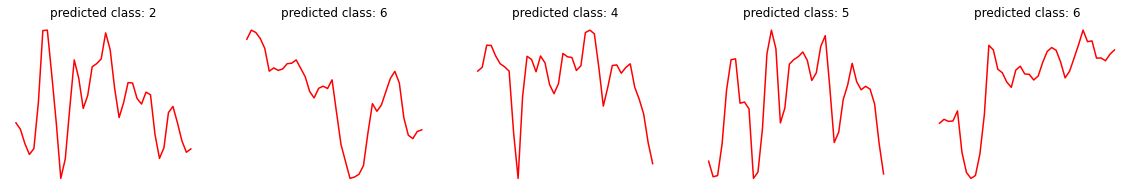

In [9]:
#@title Show some examples from the MNIST 1-D dataset

plt.figure(figsize=(20,3))

plt.subplot(151)
plt.plot(dataset['x'][0], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][0]))

plt.subplot(152)
plt.plot(dataset['x'][1], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][1]))

plt.subplot(153)
plt.plot(dataset['x'][2], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][2]))

plt.subplot(154)
plt.plot(dataset['x'][3], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][3]))

plt.subplot(155)
plt.plot(dataset['x'][4], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][4]))

Text(0.5, 1.0, 'predicted class: 9')

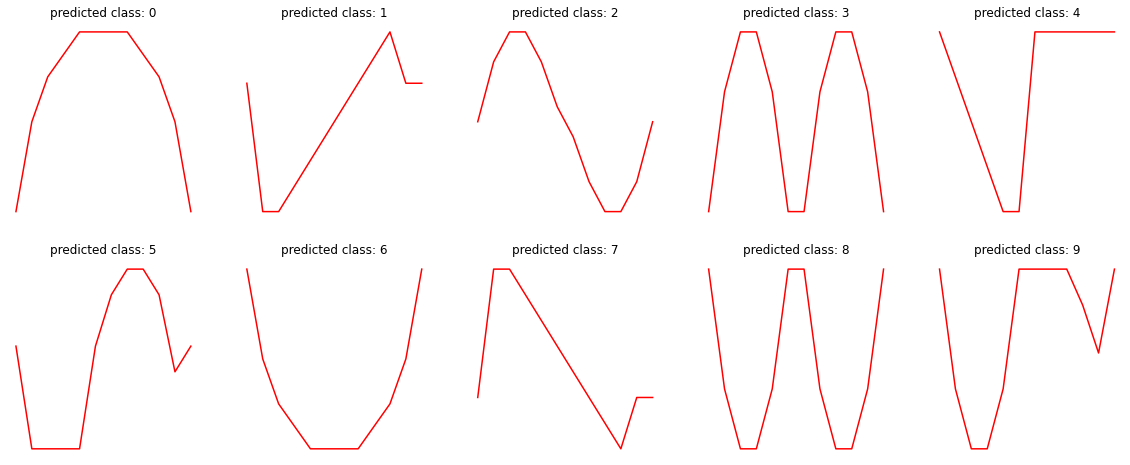

In [10]:
#@title Show the digit templates in the MNIST 1-D dataset 

plt.figure(figsize=(20,8))

plt.subplot(251)
plt.plot(dataset['templates']['x'][0], 'r')
plt.axis('off')
plt.title('predicted class: 0')

plt.subplot(252)
plt.plot(dataset['templates']['x'][1], 'r')
plt.axis('off')
plt.title('predicted class: 1')

plt.subplot(253)
plt.plot(dataset['templates']['x'][2], 'r')
plt.axis('off')
plt.title('predicted class: 2')

plt.subplot(254)
plt.plot(dataset['templates']['x'][3], 'r')
plt.axis('off')
plt.title('predicted class: 3')

plt.subplot(255)
plt.plot(dataset['templates']['x'][4], 'r')
plt.axis('off')
plt.title('predicted class: 4')

plt.subplot(256)
plt.plot(dataset['templates']['x'][5], 'r')
plt.axis('off')
plt.title('predicted class: 5')

plt.subplot(257)
plt.plot(dataset['templates']['x'][6], 'r')
plt.axis('off')
plt.title('predicted class: 6')

plt.subplot(258)
plt.plot(dataset['templates']['x'][7], 'r')
plt.axis('off')
plt.title('predicted class: 7')

plt.subplot(259)
plt.plot(dataset['templates']['x'][8], 'r')
plt.axis('off')
plt.title('predicted class: 8')

plt.subplot(2,5,10)
plt.plot(dataset['templates']['x'][9], 'r')
plt.axis('off')
plt.title('predicted class: 9')

Saving the dataset

In [11]:
f = open("MNIST1D.pkl","wb")
pickle.dump(dataset,f)
f.close()



---

# **ECE1512 Project_A Solution Part 1: 1-D Digit Classification**

## Task 1:1-Dimensional digit classification

### Task 1-1: Model Creation

**Creating model :**

A 1-Dimensional CNN, containing 3 convolutional layers, followed by a fully-connected output layer.

In [12]:
##Task1-Question1
weight_decay = 5e-4
model = Sequential()
#Your code starts from here 

model.add(Conv1D(filters=25,kernel_size=5,strides=1, activation='relu',padding='same',input_shape = (40,1),
                 kernel_regularizer=tensorflow.keras.regularizers.l2(weight_decay)))

model.add(Conv1D(filters=25,kernel_size=3,strides=1, activation='relu',padding='same',
                 kernel_regularizer=tensorflow.keras.regularizers.l2(weight_decay)))

model.add(Conv1D(filters=25,kernel_size=3,strides=1, activation='relu',padding='same',
                 kernel_regularizer=tensorflow.keras.regularizers.l2(weight_decay)))

model.add(Flatten())

model.add(Dense(activation='softmax',units = 10))

##

### Task 1-2: Training the model

Compiling the model

Loss function: Cross-entropy

Optimizer: Stochastic Gradient Descent (SGD) (learning rate = 0.01)

Tensorboard: For recording the training procedure

In [13]:
model.compile(optimizer=tensorflow.keras.optimizers.SGD(learning_rate=0.01),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x=np.expand_dims(dataset['x'], axis=-1), y=dataset['y'], validation_split=0.1, epochs=200)

Epoch 1/200
113/113 [==============================] - 2s 8ms/step - loss: 2.3127 - accuracy: 0.1406 - val_loss: 2.2920 - val_accuracy: 0.1275
Epoch 2/200
113/113 [==============================] - 1s 6ms/step - loss: 2.2375 - accuracy: 0.1697 - val_loss: 2.1737 - val_accuracy: 0.1650
Epoch 3/200
113/113 [==============================] - 1s 6ms/step - loss: 2.0508 - accuracy: 0.2089 - val_loss: 1.9408 - val_accuracy: 0.2275
Epoch 4/200
113/113 [==============================] - 1s 6ms/step - loss: 1.8570 - accuracy: 0.2581 - val_loss: 1.8062 - val_accuracy: 0.2625
Epoch 5/200
113/113 [==============================] - 1s 6ms/step - loss: 1.7613 - accuracy: 0.2986 - val_loss: 1.7408 - val_accuracy: 0.3025
Epoch 6/200
113/113 [==============================] - 1s 6ms/step - loss: 1.6967 - accuracy: 0.3278 - val_loss: 1.6780 - val_accuracy: 0.3575
Epoch 7/200
113/113 [==============================] - 1s 6ms/step - loss: 1.6316 - accuracy: 0.3611 - val_loss: 1.6138 - val_accuracy: 0.3475

### Task 1-3: Plotting the training progress

#### Task 1-3-a: Plot for loss curve and for accuracy curve

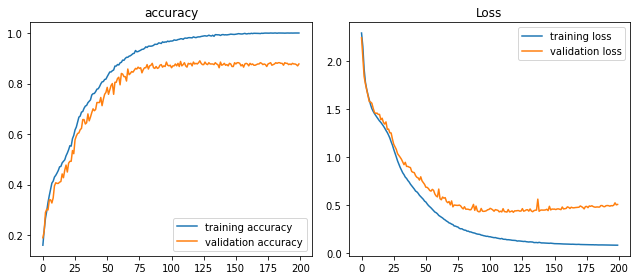

In [12]:
## Loss And Accuracy Curve
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.plot(history.history['val_accuracy'],label = 'validation accuracy')
plt.title('accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'],label = 'training loss')
plt.plot(history.history['val_loss'],label = 'validation loss')
plt.title('Loss')
plt.legend()
plt.tight_layout(rect = [0,0,1.5,1])
plt.show()

#### Task 1-3-b: Overall classification accuracy on the test set

In [13]:
## Overall Accuracy
y_pred = model.predict(np.expand_dims(dataset['x_test'], axis=-1)).argmax(axis=-1)
metrics.accuracy_score(y_pred,dataset['y_test'])

0.906

#### Task 1-3-c: Class-wise classification accuracy for all classes

In [14]:
## Class-wise Classification Accuracy for all class
acc = []
for i in range(10):
  class_ind = np.where(dataset['y_test']==i)  
  predicted = y_pred[class_ind[0]]
  print('class: {0}, accuracy: {1}'.format(i,metrics.accuracy_score(predicted,dataset['y_test'][class_ind[0]])))

class: 0, accuracy: 1.0
class: 1, accuracy: 0.9326923076923077
class: 2, accuracy: 0.8764044943820225
class: 3, accuracy: 0.9811320754716981
class: 4, accuracy: 0.9339622641509434
class: 5, accuracy: 0.8163265306122449
class: 6, accuracy: 0.9494949494949495
class: 7, accuracy: 0.875
class: 8, accuracy: 0.9285714285714286
class: 9, accuracy: 0.7549019607843137


#### Task 1-3-d: Plot the classification ROC and AUC curves for each class

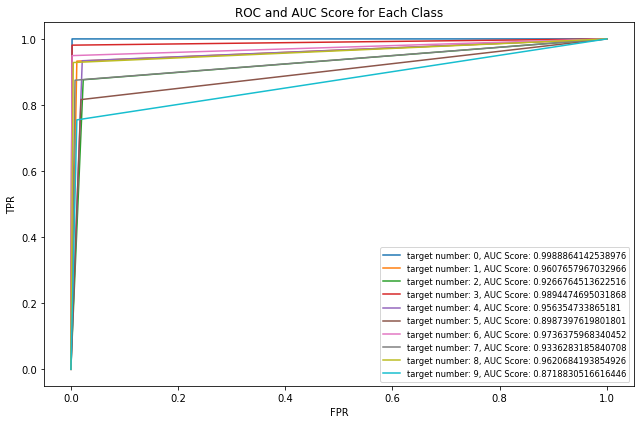

In [15]:
#ROC and AUC Curve
from sklearn.preprocessing import LabelBinarizer
y_test = dataset['y_test']
lb = LabelBinarizer()
lb.fit(y_test)
y_test = lb.transform(y_test)
y_pred_transformed = lb.transform(y_pred)

for i in range(10):
  fpr, tpr, thresholds = metrics.roc_curve(y_test[:,i].astype(int), y_pred_transformed[:,i])
  plt.plot(fpr, tpr,label = "target number: {0}, AUC Score: {1}".format(i,metrics.auc(fpr,tpr)))
plt.legend(loc='best', fontsize = 'small')
plt.title('ROC and AUC Score for Each Class')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.tight_layout(rect = [0,0,1.5,1.5])

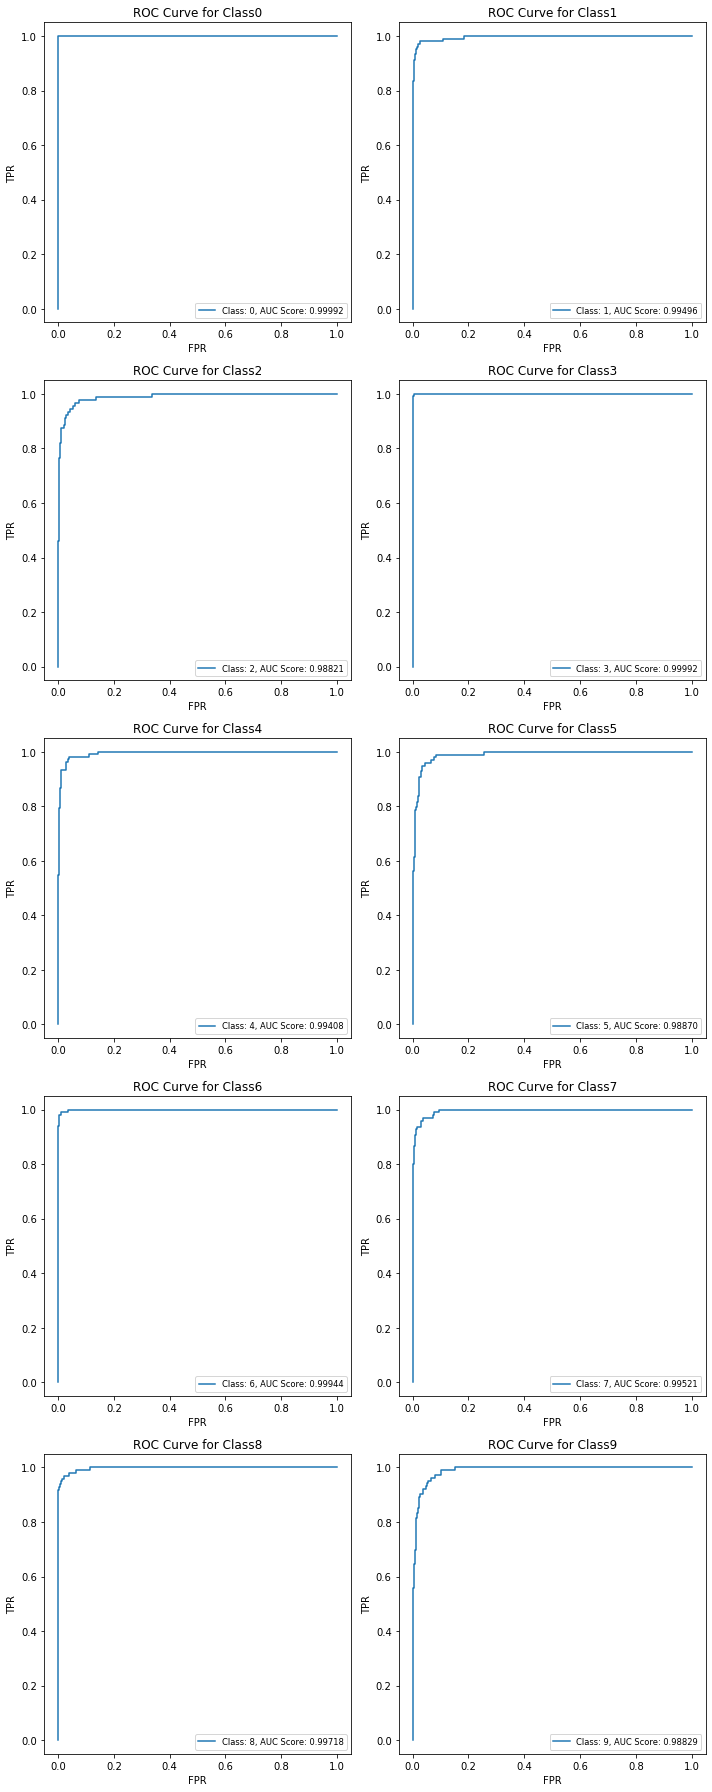

In [16]:
#ROC and AUC Curve
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score
y_test = dataset['y_test']
lb = LabelBinarizer()
lb.fit(y_test)
y_test = lb.transform(y_test)
y_pred_transformed = lb.transform(y_pred)
y_score = model(dataset['x_test'])

fig, ax = plt.subplots(5,2,figsize=(10,25))
i = 0
for row in range(5):
  for col in range(2):
    fpr, tpr, thresholds = metrics.roc_curve(y_test[:,i].astype(int), y_score[:,i])

    ax[row,col].plot(fpr, tpr,label = "Class: {0}, AUC Score: {1:.5f}".format(i,metrics.auc(fpr,tpr)))    
    ax[row,col].legend(loc='best', fontsize = 'small')
    ax[row,col].set_title('ROC Curve for Class{}'.format(i))
    ax[row,col].set(xlabel='FPR', ylabel='TPR')
    i+=1

fig.tight_layout()

#### Task 1-3-e: Plot the normalized confusion matrix

In [17]:
## Confusion Matrix
print(metrics.confusion_matrix(y_pred,dataset['y_test'],normalize='true'))

[[0.98076923 0.         0.         0.         0.         0.
  0.00961538 0.00961538 0.         0.        ]
 [0.         0.90654206 0.         0.         0.         0.04672897
  0.02803738 0.         0.         0.01869159]
 [0.         0.03030303 0.78787879 0.         0.01010101 0.1010101
  0.         0.05050505 0.         0.02020202]
 [0.         0.         0.         0.98113208 0.         0.
  0.         0.01886792 0.         0.        ]
 [0.         0.02542373 0.         0.         0.83898305 0.
  0.         0.         0.01694915 0.11864407]
 [0.         0.01030928 0.05154639 0.         0.02061856 0.82474227
  0.01030928 0.03092784 0.01030928 0.04123711]
 [0.         0.         0.01041667 0.         0.         0.
  0.97916667 0.01041667 0.         0.        ]
 [0.         0.         0.04395604 0.02197802 0.         0.01098901
  0.         0.92307692 0.         0.        ]
 [0.         0.         0.         0.         0.01052632 0.
  0.         0.         0.95789474 0.03157895]
 [0.  

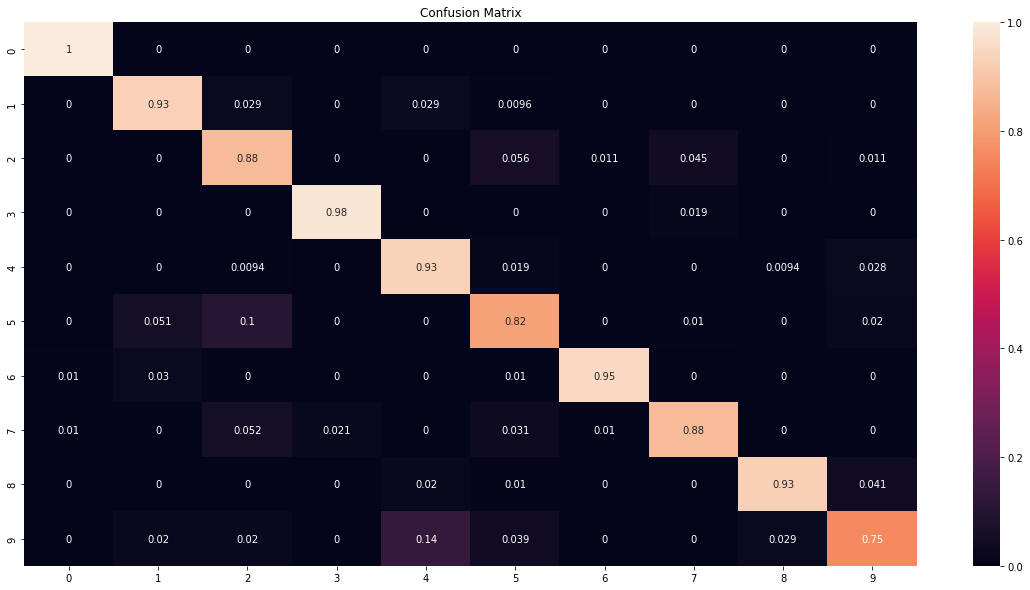

In [22]:
## Confusion Matrix
import seaborn as sn

confusion_matrix = metrics.confusion_matrix(dataset['y_test'], y_pred,normalize='true')
df_confusion_matrix = pd.DataFrame(confusion_matrix, index = [i for i in range(0,10,1)],
                  columns = [i for i in range(0,10,1)])
plt.figure(figsize=(20,10))
sn.heatmap(df_confusion_matrix, annot=True)
plt.title('Confusion Matrix')
plt.show()

#### Tassk 1-3-f: Precision, Recall, and F-1 score on the test set

In [19]:
## Presion Recall F1 Score
print(metrics.classification_report(y_pred,dataset['y_test']))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       104
           1       0.93      0.91      0.92       107
           2       0.88      0.79      0.83        99
           3       0.98      0.98      0.98       106
           4       0.93      0.84      0.88       118
           5       0.82      0.82      0.82        97
           6       0.95      0.98      0.96        96
           7       0.88      0.92      0.90        91
           8       0.93      0.96      0.94        95
           9       0.75      0.89      0.81        87

    accuracy                           0.91      1000
   macro avg       0.90      0.91      0.90      1000
weighted avg       0.91      0.91      0.91      1000



Show  some  examples  of  the  success/failure  cases  of  the  model.  Among  which  two 
classes  misclassification  happens  the  most?  Provide  your  insights  and  support  your 
answers with analytic reasons. [1.25 Marks] 

### Task 1-4:

Show some examples of the success/failure cases of the model. Among which two classes misclassification happens the most? Provide your insights and support your answers with analytic reasons.

***Answer:*** According to the classification accuracy on each single class, we can see that predictions on  number 4 and number 9 has the lowest accuracy. It happens because 4, 9 and 6 have similar patterns, which confuses the model.

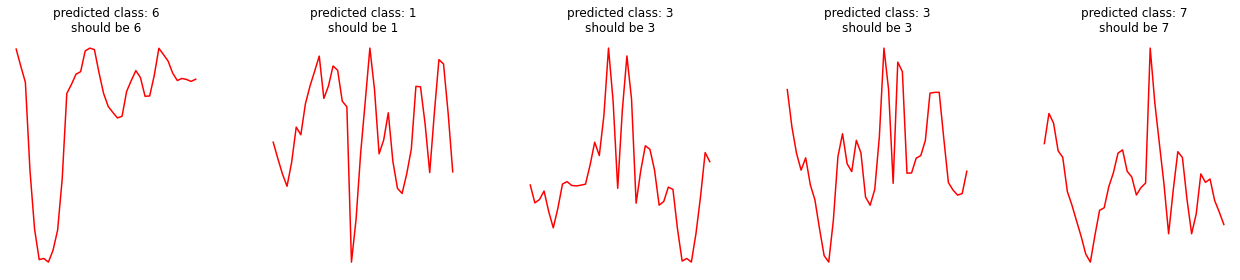

In [20]:
#Success Cases

Success_cases = np.where(y_pred == dataset['y_test'])[0]

for i in range(5):
  plt.subplot(1,5,i+1)
  choice = np.random.choice(Success_cases)
  plt.plot(dataset['x_test'][choice], 'r')
  plt.axis('off')
  plt.title('predicted class: '+str(y_pred[choice]) + "\nshould be {0}".format(dataset['y_test'][choice]))

plt.tight_layout(rect = [0,0,3,1])


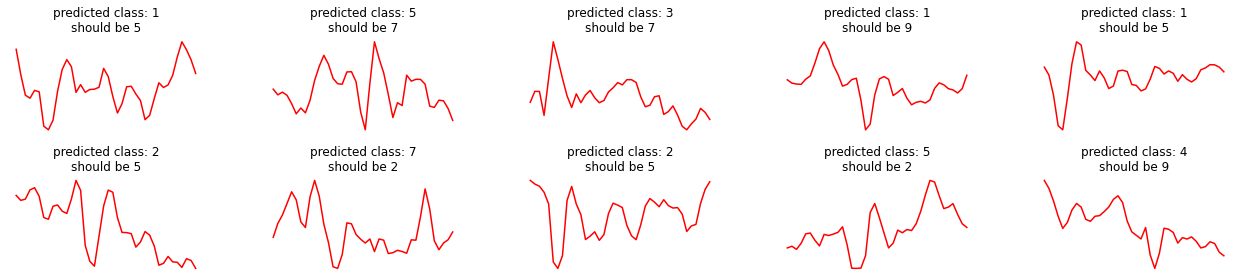

In [21]:
#Failed Cases

Failed_cases = np.where(y_pred != dataset['y_test'])[0]

for i in range(10):
  plt.subplot(2,5,i+1)
  choice = np.random.choice(Failed_cases)
  plt.plot(dataset['x_test'][choice], 'r')
  plt.axis('off')
  plt.title('predicted class: '+str(y_pred[choice]) + "\nshould be {0}".format(dataset['y_test'][choice]))

plt.tight_layout(rect = [0,0,3,1])

## Task 2: CNN interpretation

### Task 2-2: 
Apply your selected method(s) on the CNN trained on the MNIST 1-D dataset, taking different inputs

In [ ]:
from xai_utils import *

Take a test sample

In [ ]:
x_test = dataset['x_test']
y_test = dataset['y_test']

Give the input to the model (Prediction)

In [ ]:
index = int(np.floor(np.random.rand()*1000))
input = np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)
label = y_test[index]
print('Correct digit: '+str(label))
print('Predicted digit: '+str(np.argmax(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy())))
print('Confidence score for the correct label: '+str(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy()[0,label]))

Correct digit: 2
Predicted digit: 2
Confidence score for the correct label: 0.99765694


In [1]:

def get_img_array(img_path, size=(299, 299)):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def get_gradients(img_input, top_pred_idx):
    """Computes the gradients of outputs w.r.t input image.

    Args:
        img_input: 4D image tensor
        top_pred_idx: Predicted label for the input image

    Returns:
        Gradients of the predictions w.r.t img_input
    """
    images = tf.cast(img_input, tf.float32)
    #images = tf.convert_to_tensor(img_input)
    with tf.GradientTape() as tape:
        tape.watch(images)
        preds = model(images)
        top_class = preds[:, top_pred_idx]

    grads = tape.gradient(top_class, images)
    return grads


def get_integrated_gradients(img_input, top_pred_idx, baseline=None, num_steps=50):
    """Computes Integrated Gradients for a predicted label.

    Args:
        img_input (ndarray): Original image
        top_pred_idx: Predicted label for the input image
        baseline (ndarray): The baseline image to start with for interpolation
        num_steps: Number of interpolation steps between the baseline
            and the input used in the computation of integrated gradients. These
            steps along determine the integral approximation error. By default,
            num_steps is set to 50.

    Returns:
        Integrated gradients w.r.t input image
    """
    # If baseline is not provided, start with a black image
    # having same size as the input image.
    img_size = (40,)
    if baseline is None:
        baseline = np.zeros(img_size).astype(np.float32)
    else:
        baseline = baseline.astype(np.float32)

    # 1. Do interpolation.
    img_input = img_input.astype(np.float32)
    interpolated_image = [
        baseline + (step / num_steps) * (img_input - baseline)
        for step in range(num_steps + 1)
    ]
    interpolated_image = np.array(interpolated_image).astype(np.float32)

    # 2. Preprocess the interpolated images
#    interpolated_image = xception.preprocess_input(interpolated_image)

    # 3. Get the gradients
    grads = []
    for i, img in enumerate(interpolated_image):
        img = tf.expand_dims(img, axis=0)
        grad = get_gradients(img, top_pred_idx=top_pred_idx)
        grads.append(grad[0])
    grads = tf.convert_to_tensor(grads, dtype=tf.float32)

    # 4. Approximate the integral using the trapezoidal rule
    grads = (grads[:-1] + grads[1:]) / 2.0
    avg_grads = tf.reduce_mean(grads, axis=0)

    # 5. Calculate integrated gradients and return
    integrated_grads = (img_input - baseline) * avg_grads
    return integrated_grads


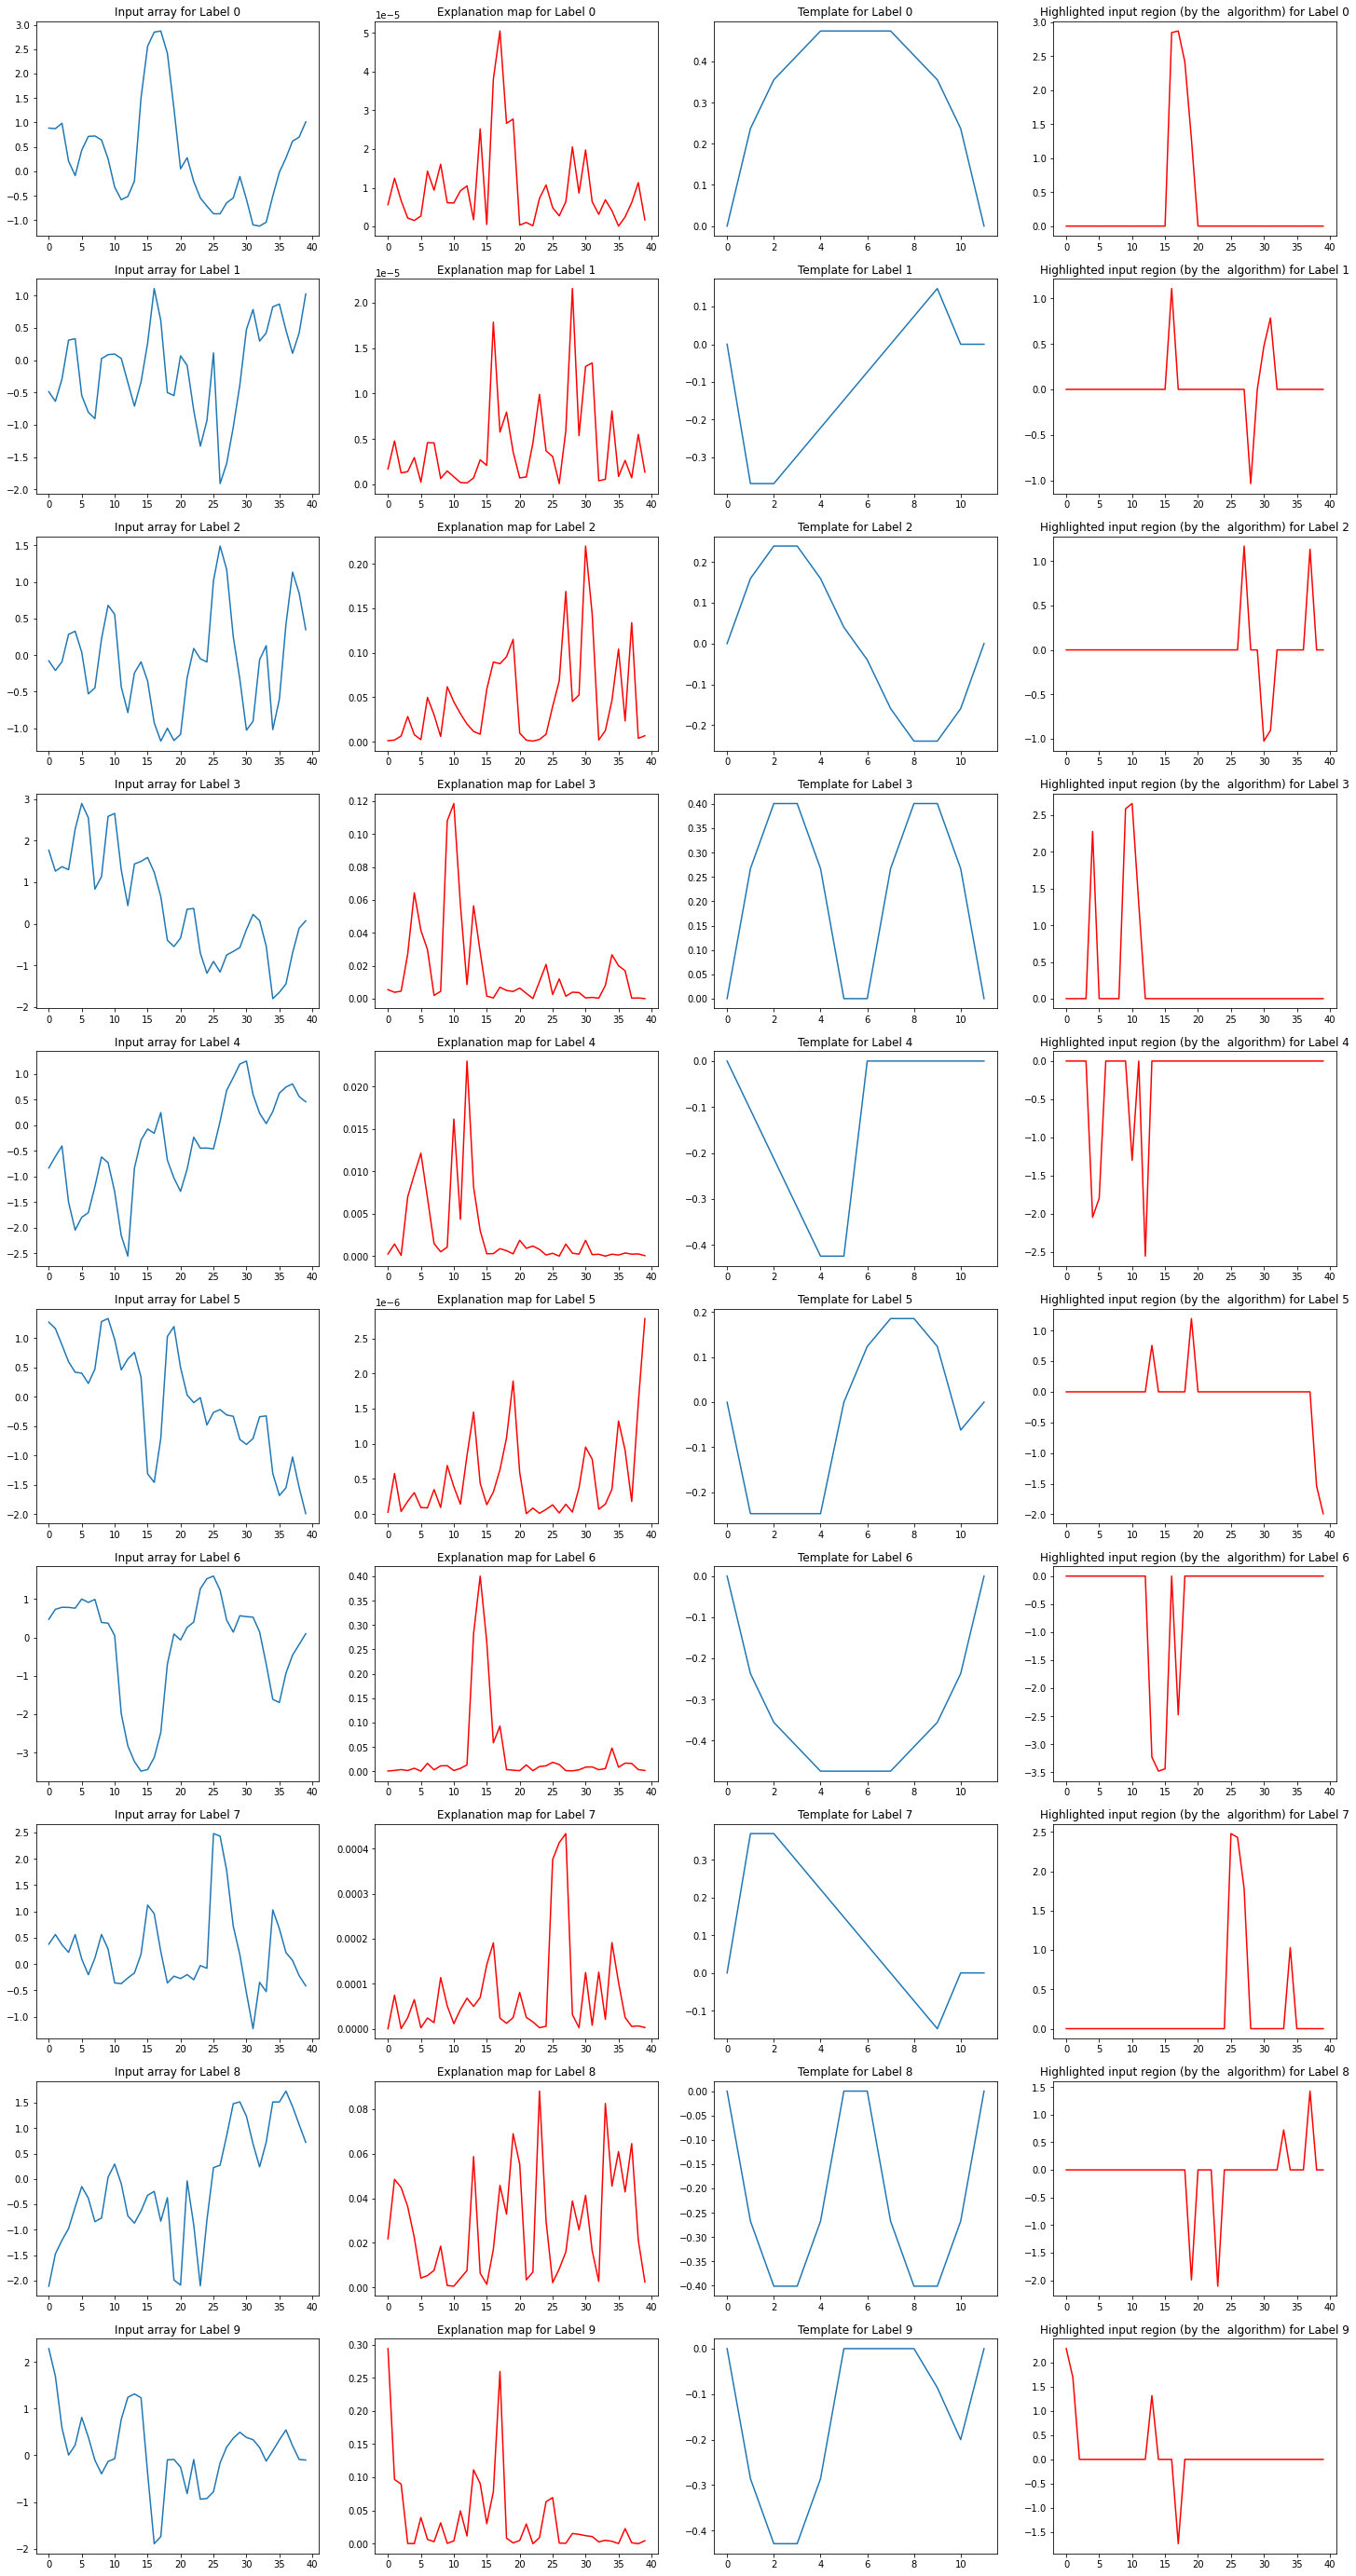

In [29]:
### 1-dimensional explanation map of 10 different label
plt.figure(figsize=(25,50))
for i in range(10):

  ## Obtain the first index that y_test is equal to the class i
  index = np.where(dataset['y_test'] == i)[0][0]

  input = np.expand_dims(np.expand_dims(dataset['x_test'][index], axis=0), axis=-1)
  label = dataset['y_test'][index]
  #print('\nCorrect digit: '+str(label))
  #print('Predicted digit: '+str(np.argmax(model(np.expand_dims(np.expand_dims(dataset['x_test'][index], axis=0), axis=-1)).numpy())))
  #print('Confidence score for the correct label: '+str(model(np.expand_dims(np.expand_dims(dataset['x_test'][index], axis=0), axis=-1)).numpy()[0,label]))
  
  input = np.expand_dims(dataset['x_test'][index],axis = 0)

  preds = model.predict(np.expand_dims(dataset['x'][index],axis = 0))
  top_pred_idx = tensorflow.argmax(preds[0])


  igrads = get_integrated_gradients(
      dataset['x_test'][index], top_pred_idx=top_pred_idx, num_steps=50
  )

  explanation  = np.abs(igrads)
  threshold = np.sort(explanation)[-5]

  plt.subplot(10,4,4*i+1)
  plt.plot(input[0])
  plt.title('Input array for Label %d' %(label))

  plt.subplot(10,4,4*i+2)
  plt.plot(explanation, 'r')
  plt.title('Explanation map for Label %d' %(label))

  plt.subplot(10,4,4*i+3)
  plt.plot(dataset['templates']['x'][label])
  plt.title('Template for Label %d' %(label))
  input = np.expand_dims(np.expand_dims(dataset['x_test'][index], axis=0), axis=-1)
  plt.subplot(10,4,4*i+4)
  plt.plot((input[0,:,0]*(explanation>threshold)), 'r')
  plt.title('Highlighted input region (by the  algorithm) for Label %d' %(label))
plt.show()

#### Task 2-2-b:
Qualitatively report the explanation maps you achieved and compare them with the templates presented for each of the digits. Discuss your results. Do you think the highlighted region is similar to the template corresponding to the digit predicted by your model? Do you think the explanation map shows the local behavior of the model well?

**Answer:**

*  Integrated Gradients
  *   Highlighted regions that are similar to the template: 9, 8, 7, 4, 3, 2, 1, 0. 
  *  Highlighted regions that are not similar: 5 and 6. For 5, although the model have high confidence score, only a small peak is generated in the highlighted region. For 6, instead of one entire concave up, the highlighted region showed two separate narrow concave up but in similar region.
  * For explanation map, we can generally see a peak of feature importance in the location where there is a similar shape to the template, for example, for digit 7, we can see a peak of explanation map at around 25-30, which is exactly the where the template shape occurs. We can also sometimes see multiple peaks in single explanation map, that may because in one sample there are multiple locations that contain similar shape to the template, for example, for digit 2, there are two peaks in the explanation map respectively in 15-20 and 25~30, that may because similar 'Sine-wave' shape occur twice in those two locations.
        









## Task4: Quantitative evaluation of the attribution methods

### Task4-1:
Apply the “Drop%” and “Increase%” metrics to evaluate the performance of your selected
attribution methods when applied to the CNN trained on both datasets. For the MNIST-1D dataset, take the parameter “k” shown in Figure 2 as 30%. This parameter can be tuned using the input argument frac in the function calculate_drop_increase(). Take this parameter for the HMT dataset as 90%. For both datasets, calculate the average drop% and average increase% on the whole test set.

In [ ]:
def calculate_drop_increase(images, model, exmap, class_index, frac=0.15):
    '''
    inputs:
        images: a 4-D image of size (1 x H x W x 3)
          containing an image in RGB format and of size (H x W)
        model: The base model
        exmap: a given explanation map whose completeness is to be evaluated.
        class_index: The class to whom the explanation map is related to.
        frac: The fraction of top pixels selected.
    returns:v
        a tuple with 4 calculates values:
        (drop, increase, original_pred, eplanation_pred)
        drop (float): drop rate (between 0 and 1)
        increase (boolean): "1" if increase happened
        original_pred: confidence score for original image
        explanation_pred:  confidence score for the selected top pixels of the image.
    '''
    predictions = model.predict(images)
    #print(images.shape)
    # Pre-processing image 
    img=images[0,:,:]
    #img=img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Getting the prediction for image
    Y=predictions[0][class_index]
    
    grad_array=np.reshape(exmap, (-1,))
    array_size=int(grad_array.shape[0]*frac)
    thr=np.flip(sorted(grad_array))[array_size]
    exmap1_msk=(exmap>thr)
    exmap1_thr=np.zeros(shape=(1,40,1))
    exmap1_thr=img*exmap1_msk
    ex_predictions = model.predict(exmap1_thr)[0]
    O1=ex_predictions[class_index]
    etta=(Y-O1)/(Y+1e-100)
    return (etta*(etta>0), 1*(etta<0), Y, O1)

In [ ]:
vis.return_importance(
  image=input,
  gradients=grads[0].numpy(),
  integrated_gradients=igrads.numpy(),
  clip_above_percentile=99,
  clip_below_percentile=0,
  ).shape

(40,)

In [ ]:
# Method 2: Integrated Gradient
drop_rate = 0.
increase_rate = 0.
for index in range(1000):
  input = np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)
  prediction=model(input).numpy()
  top_pred_idx = tensorflow.argmax(preds[0])
  prediction=model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy()
  igrads = get_integrated_gradients(
  dataset['x_test'][index], top_pred_idx=top_pred_idx, num_steps=50
)
  explanation_map    = np.abs(igrads)
  explanation_map = np.expand_dims(explanation_map, axis=-1)
  drop, increase, _, _= calculate_drop_increase(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1), model, explanation_map, class_index=np.argmax(prediction[0]), frac=0.3)
  drop_rate += drop
  increase_rate += increase
drop_rate /= 1000
increase_rate /= 1000

print('Method 2: Integrated Gradient')
print('Drop rate: %.3f'%(drop_rate))
print('Increase rate: %.3f'%(increase_rate))

Method 2: Integrated Gradient
Drop rate: 0.355
Increase rate: 0.209
